In [21]:
# 기본적인 임포트
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# 데이터 가져오기
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer( )

In [23]:
# 데이터 분할
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size=0.2, random_state=42)

In [24]:
# 검증세트 분할
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


In [25]:
# 넘파이로 표준화 구현하기
train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis = 0)
x_train_scaled = (x_train - train_mean) / train_std

In [26]:
# 올바른 전처리
x_val_scaled = (x_val - train_mean) / train_std

# 과대적합과 과소적합

과대적합이란 모델이 훈련세트에만 좋은 성능을 내고 검증세트에는 나쁜 성능을 내는 경우다.  
일반적으로, 훈련세트 정확도가 99%, 검증세트 정확도가 80%라면 과대적합을 의심할 수 있다.

</br>

과소적합은 그냥 성능자체가 구린경우다.  

</br>

즉, 우리는 성능도 우수하면서 검증세트 정확도와 훈련세트 정확도의 차이가 거의 없는  
모델을 만드는 것이 훌륭한 모델을 만드는 것이라 할 수 있다.

## 에포크 손실함수을 통한 과대적합과 과소적합 분석하기

훈련세트의 손실은 에포크가 진행될수록 감소하지만  
검증세트의 손실은 에포크의 횟수가 최적점을 지나면 오히려 상승한다.  
최적점 이후에도 훈련을 진행할 경우, 훈련세트 전용이 되어버리기 때문이다.  
  
고로 적절한 에포크 횟수를 찾는 것이 중요하다.  

## 적절한 편향-분산 트레이드오프를 선택
앞에서 과소적합된 모델은 편향되었다고 하고 과대적합된 모델은 분산이 크다고 한다.  
분산을 챙기면 편향되고 편향을 해결하면 분산이 커진다.  
때문에 이 둘 사이에서 적절한 값을 찾아내야 한다.  
</br>

지난번에 만든 클래스 코드를 변경하자

In [27]:
# SingleLayer 클래스 수정
# 지난 시간에 만든 코드
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b    # 직선 방정식을 계산
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화
        self.b = 0                                 # 절편을 초기화
        self.w_history.append(self.w.copy())       # 가중치를 기록
        np.random.seed(42)                         # 랜덤 시드를 지정
        for i in range(epochs):                    # epochs만큼 반복
            loss = 0
            # 인덱스를 섞는다.
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 더한다
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= self.lr * b_grad         # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [28]:
# 모델 훈련
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

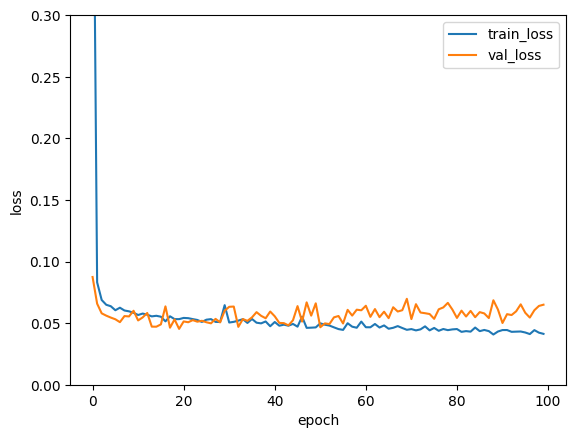

In [29]:
# 그래프 그리기
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

이 모델은 20번의 에포크 이후에는 훈련할 필요가 없을 것 같다.  
대략 50번쯤을 보면 오히려 벌어지는 것을 볼 수 있다.  

In [30]:
# 훈련 조기종료
layer4 = SingleLayer( )
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.989010989010989

성능이 조금 더 향상되었다.

---
# 규제

과대적합을 해결하는 대표적인 방법으로 가중치 규제가 있다.  
  
모델이 몇 개의 데이터에 집착하면 새로운 데이터에 적응하지 못하기에  
좋은 성능을 가졌다고 할 수 없다.  
이런 경우를 모델이 일반화되지 않았다고 표현한다.  
이럴 때 규제를 사용해 가중치를 제한하면 모델이 몇 개의 데이터에 집착하지  
않으므로 일반화 성능을 높일 수 있다.  
</br>

대표적인 규제기법인 L1 규제와 L2 규제에 대해 알아보자


# L1 규제

L1 노름은 가중치의 절대값으로 다음과 같이 정의된다.

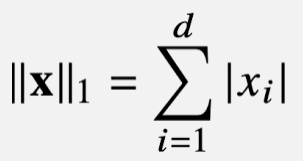

x는 벡터를 의미한다.  
앞으로 소문자 알파벳은 벡터를 의미한다.  
아직 사용되지는 않았지만 대문자 알파벳은 행렬을 의미한다.  
  
L1규제는 '가중치의 절댓값을 손실함수에 더한 것'으로 이해해도 된다.  
다음은 로지스틱 손실함수다.  


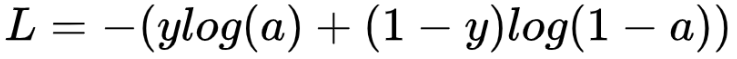

이 함수에 L1 노름을 더하면 L1 규제가 만들어진다.  
이 때, L1 노름을 그냥 더하지 않고 규제의 양을 조절하는 파라미터 a를 L1노름에 곱해야 한다.  
a는 하이퍼파라미터다.  
완성된 L1 규제를 벡터 x에 대해 미분하면 x값의 부호만 남는다.  
미분한 식을 x에 대해 확장해서 전개한다.  

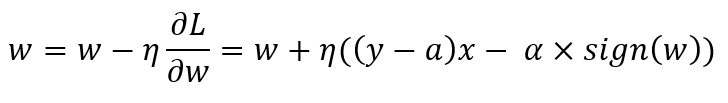


이를 파이썬 코드로 작성하면 다음과 같다.

```
w_grad += alpha * np.sign(w)
```
여기에서, alpha가 규제 하이퍼 파라미터다.  
여기서는 절편에 대해서는 규제를 하지 않는다.  
절편은 모델에 영향을 미치는 방식이 가중치와 다르기 때문이다.  


### 라쏘모델

회귀모델에 L1규제를 추가한 것이 라쏘모델이라고 한다.  
사이킷 런에서는 sklearn.linear_model.Lasso 클래스에서 라쏘모델을 제공한다.  
L1 규제는 규제 하이퍼 파라미터 a에 많이 의존한다.  
즉, 가중치의 크기에 따라 규제의 양이 변하지 않으므로 규제효과가 좋다고 할 수 없다.  
이번엔 L2규제에 대해 알아보자

---

# L2 규제

L2규제는 손실함수에 가중치에 대한 L2 노름의 제곱을 더한다.  
L2 노름은 다음과 같이 정의한다.  



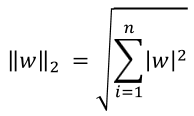

여기서는 벡터값을 w로 나타냈다.(사람마다 사용하는 알파벳이 다를 수 있다.)  

아까 보여준 로지스틱 손실함수에 L2 노름의 제곱(그러니까 위 식에서 루트를 없앤)  
값에 하이퍼 파라미터 a를 곱한 다음 1/2를 곱한다.  
1/2은 미분 결과를 나타내기 위해 추가했다.  


## L2규제의 미분
과정은 이전과 동일하다.  
L2 규제를 미분하면 가중치 벡터 w만 남는다.

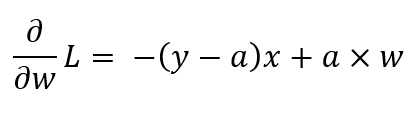

이걸 가중치 업데이트 식에 대입해 보자  

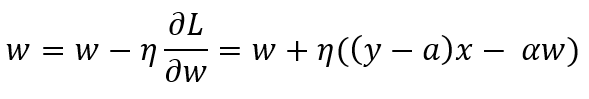

여기서 n? 은 학습률이다.  
L2 규제를 경사하강법 알고리즘에 적용하는 것도 쉽다.  
코드는 아래와 같다.
```
w_grad += alpha * w
```

### 릿지모델
회귀 모델에 L2 규제를 적용한 것을 릿지모델이라고 한다.
사이킷런에서는 sklearn.linear_model.Ridge 클래스로 제공한다.

---
# 정리
L1 규제는 다음과 같다.  
알파에 가중치 부호를 곱하여 그레이디언트에 더한다.

```
w_grad += alpha * np.sign(w)
```

L2 규제는 다음과 같다.  
알파에 가중치를 곱해 그레이디언트에 더한다.

```
w_grad += alpha * w
```

---
# 적용하기


전에 만든 SingleLayer 클래스에 L1 규제와 L2 규제를 적용해보자  
__init__, fit, update_val_loss를 수정하고 reg_loss 을 추가한다.

In [31]:
# SingleLayer 클래스 수정
# 지난 시간에 만든 코드
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)

                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad
                self.b -= self.lr * b_grad 
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y) + self.reg_loss())
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) >= 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

이제 규제를 추가해보자

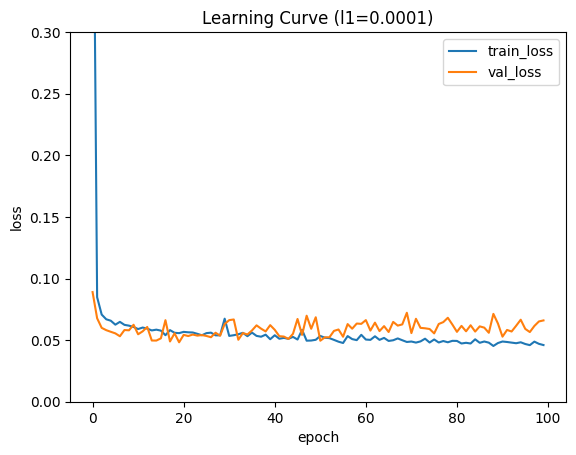

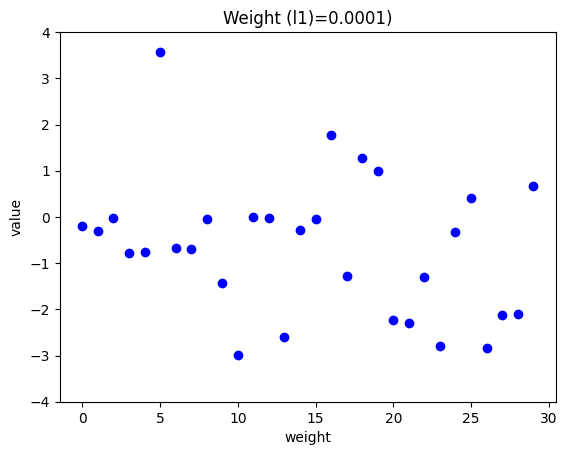

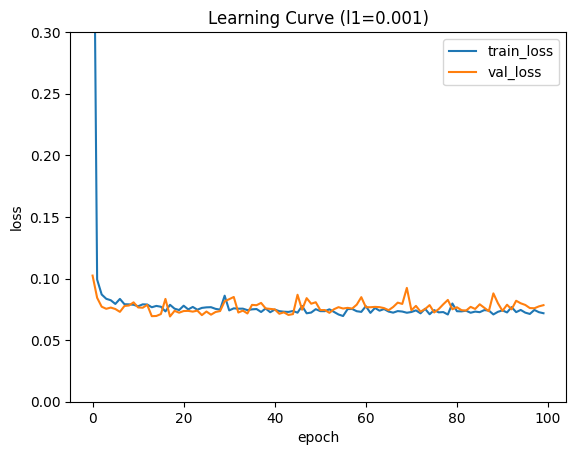

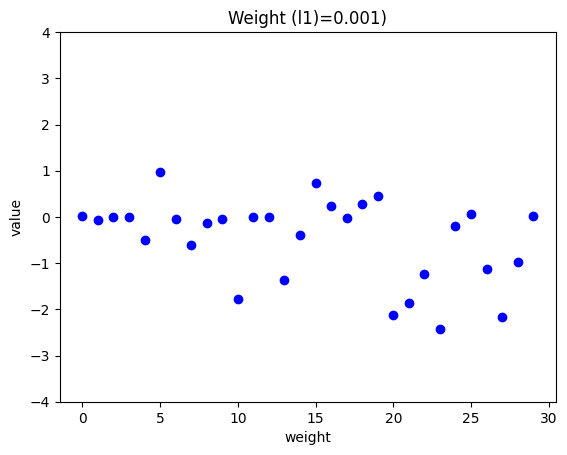

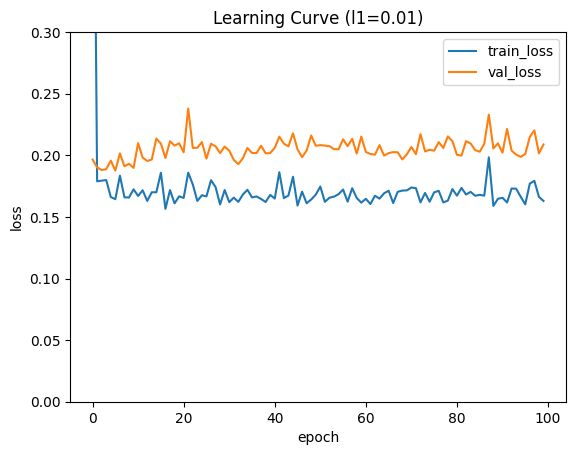

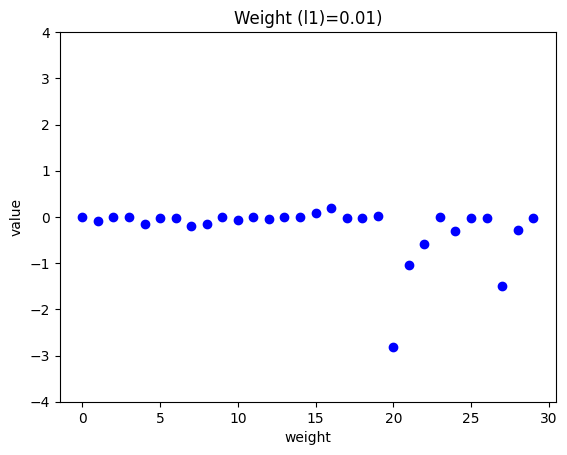

In [32]:
# cancer 데이터 세트에 L1 규제 적용하기
li_list = [0.0001, 0.001, 0.01]       # 규제 강도는 이 3가지로 하자

for l1 in li_list:
  lyr = SingleLayer(l1=l1)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l1={})'. format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l1)={})'. format(l1))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()


위는 학습 곡선 그래프, 아래는 가중치에 대한 그래프다.

In [33]:
layer5 = SingleLayer(l1-0.001)
layer5.fit(x_train_scaled, y_train, epochs = 20)
layer5.score(x_val_scaled, y_val)

0.989010989010989

결과를 보니 규제를 적용하지 않고 검증세트로 성능을 평가했을때와 동일하다.  
이 데이터 세트는 작기 때문에 규제 효과가 크게 나타나지 않는다.  
이제 L2 규제를 적용해보자

---
## L2 규제 적용

위 L1 규제할 때처럼 똑같이 L2 규제를 적용해보자

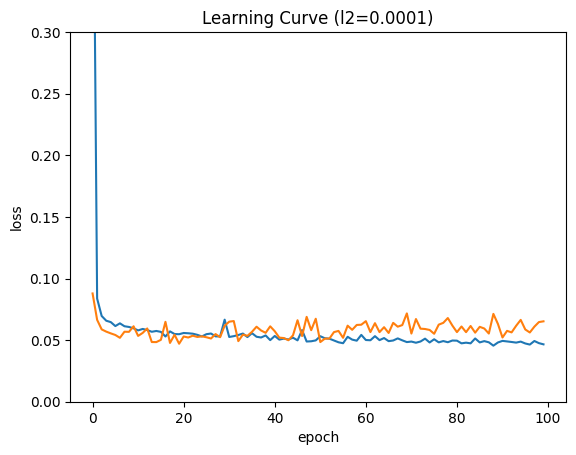

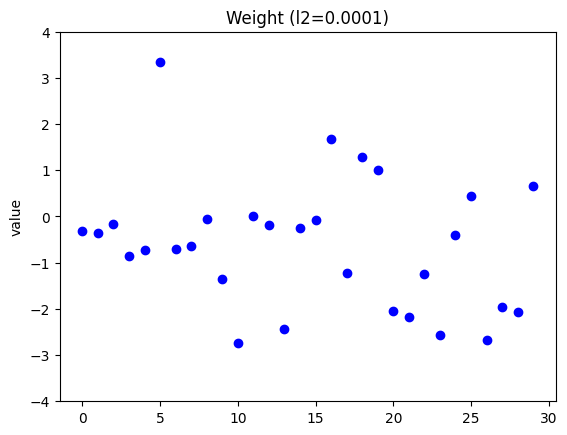

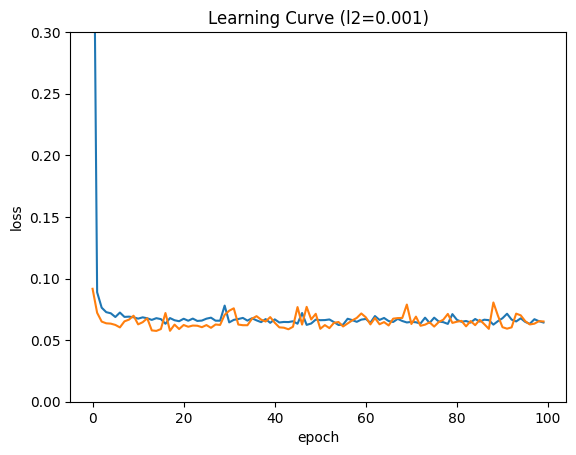

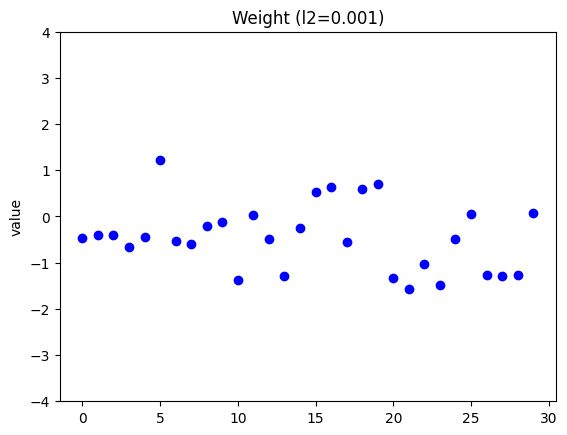

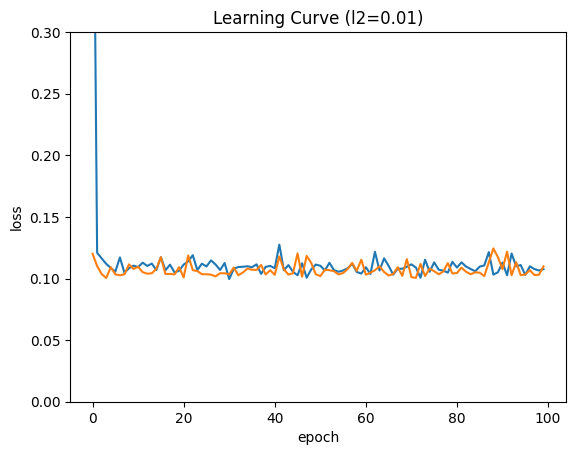

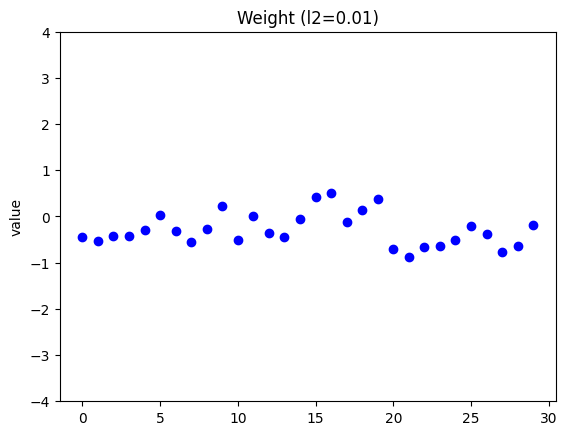

In [34]:

l2_list = [0.0001, 0.001, 0.01]
for l2 in l2_list:
  lyr = SingleLayer(l2=l2)
  lyr.fit(x_train_scaled, y_train, x_val= x_val_scaled, y_val=y_val)
  
  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l2={})'.format(l2))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l2={})'.format(l2))
  plt.ylabel('value')
  plt.ylim(-4, 4)
  plt.show()


L1규제와 비슷한 양상을 보인다.  
하지만 마지막 학습 곡선 그래프는 L2규제는 규제 강도가 강해져도  
L1처럼 과소적합이 심해지지는 않는다.  
이 모델 역시 50번 훈련하고 성능을 평가해보자

In [35]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.989010989010989

In [36]:
np.sum(layer6.predict(x_val_scaled) == y_val)

90

L1과 거의 차이가 없다.  
사실 데이터 셋의 크기가 너무 작아서 큰 차이가 없다.  
여기서는 총 90개를 올바르게 예측했다.  

---
# SGDClassifier에서 규제 사용하기
이번엔 직접 구현한 클래스가 아닌 사이킷 런으로 규제를 해보자

In [38]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.978021978021978

SingleLayer 클래스와 거의 동일한 결과가 나온다.  

---
# 교차검증

데이터 세트에서 훈련 세트와 검증 세트를 분리하면서  
우리는 데이터 부족을 경험했다.  
이럴 때 필요한 것이 바로 교차검증이다.  

</br>  
## 원리

훈련 세트를 작은 덩어리로 나누는데 이 덩어리를 폴드라 한다.  
만약 5개로 나누었다면 1~5폴드가 생기는데, 이 작은 폴드 하나를  
1번씩 검증에 사용하고 나머지는 훈련에 사용하는 것이다.  
즉, 훈련세트를 돌아가면서 검증하는 것이다.  
</br>
이때, 훈련세트를 k개의 폴드로 나누는 특징이 있기에  
k-폴드 교차검증 이라고 부른다.  

</br>

## 구현

각 폴드의 검증 점수를 저장하기 위한 변수를 선언하고  
이 값을 평균하여 최종 점수를 구한다.  


In [41]:
# 변수 저장용
validation_scores = []

In [40]:
# K-폴드 교차검증 구현
k=10                            # 폴드는 10개
bins = len(x_train_all) // k    # bins는 평균값

for i in range(k):
  start = i*bins
  end = (i+1)*bins
  val_fold = x_train_all[start:end]
  val_target = y_train_all[start:end]

  train_index = list(range(0, start)) + list(range(end, len(x_train_all)))
  train_fold = x_train_all[train_index]
  train_target = y_train_all[train_index]

  train_mean = np.mean(train_fold, axis = 0)
  train_std = np.std(train_fold, axis = 0)
  train_fold_scaled = (train_fold - train_mean) / train_std
  val_fold_scaled = (val_fold - train_mean) / train_std

  lyr = SingleLayer(l2=0.01)
  lyr.fit(train_fold_scaled, train_target, epochs = 50)
  score = lyr.score(val_fold_scaled, val_target)
  validation_scores.append(score)

print(np.mean(validation_scores))

0.9777777777777779


start와 end는 각각 폴드 샘플의 시작과 끝 인덱스다.  
나머지 부분이 바로 훈련 폴드 샘플의 인덱스가 된다.  
다음 그림처럼 train_index에 list()함수를 사용해 훈련 폴드의 인덱스를 모으고  
이것으로 train_fold와 train_target을 만든다.  


## 사이킷런으로 구현
역시나 사이킷 런에도 이런 기능을 지원하는 함수가 있다.  
이번엔 이 함수를 사용해 보자

In [43]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state = 42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np.mean(scores['test_score']))

0.850096618357488


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

표준화 전처리 과정을 수행하지 않아서 점수가 낮다.  
전처리 과정을 해주자  
사이킷 런에는 전처리 단계에서 누설되지 않도록 전처리단계와 모델 클래스를 연결해주는 pipeline 클래스를 지원한다.  
  
이 파이프라인을 사용해 전처리를 하고 다시 점수를 출력해보자

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler( ), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv = 10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle